In [ ]:
# !git clone https://github.com/THUDM/CogQA.git
# %cd CogQA/
%cd /content/drive/MyDrive/Dataset/DS310_NLP/Dataset/CogQA-master/
!pip install -r requirements.txt
!pip install redis-server redis
import redis_server
!$redis_server.REDIS_SERVER_PATH --daemonize yes

In [ ]:
#Gọi redis, tạo database client
#Nếu trong thư mục chứa notebook đã có file dump.rdb thì gọi lệnh này nó sẽ tự restore database
import redis
db = redis.StrictRedis(host = 'localhost', port=6379)

In [ ]:
#check xem có đang active không
#khi restore database thì lệnh này chưa chạy được đâu
#chờ khi nào lệnh này trả về True thì database đã được chuẩn bị xong
db.ping()

True

In [ ]:
# #Thử thêm 1 mẫu dữ liệu vào database client
# db.set('foo', 'bar')
# #Lấy dữ liệu ra bằng key "foo"
# db.get('foo')

b'bar'

In [ ]:
# #Gọi đường dẫn tới thư mục CogQA để làm cho dễ
# import sys
# sys.path.append('/content/drive/MyDrive/Dataset/DS310_NLP/Dataset/CogQA-master/')

## read_fullwiki.py

Redis is a non-SQL type of database as it does not have tables like relational databases. A popular alternative to Redis is Memcached, which is a key-value server like Redis. It has a very high performance as well.

**Redis RPUSH** <br>command inserts all the specified values at the tail of the list stored at the key. If the key does not exist, it is created as an empty list before performing the push operation. When the key holds a value that is not a list, an error is returned. <br>

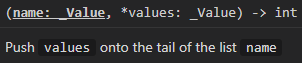

```
redis 127.0.0.1:6379> RPUSH mylist "hello" 
(integer) 1 
redis 127.0.0.1:6379> RPUSH mylist "foo" 
(integer) 2 
redis 127.0.0.1:6379> RPUSH mylist "bar" 
(integer) 3 
redis 127.0.0.1:6379> LRANGE mylist 0 -1 
1) "hello"
2) "foo" 
3) "bar"
```

<img src = "https://linuxhint.com/wp-content/uploads/2022/08/word-image-208549-1.png">

**db.lrange(name, start, end):** <br>
* Redis LRANGE command returns the specified elements of the list stored at the key. The offsets start and stop are zero-based indexes, with 0 being the first element of the list (the head of the list), 1 being the next element, and so on. These offsets can also be negative numbers indicating offsets starting at the end of the list. For example, -1 is the last element of the list, -2 the penultimate, and so on.

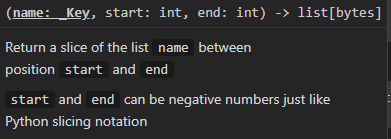

<img src = "https://jeffdevslife.com/p/redis-list/cover.jpg">

<img src="https://miro.medium.com/max/521/0*K3u3LwGWGv7g-CXE.jpg">

In [ ]:
#read_fullwiki.py
import bz2
import json
from tqdm import tqdm
import os
from itertools import chain
import re
import pickle as pkl
from urllib.parse import unquote
HTML_SYM = re.compile(r'<(.*?)>')
EDGE_XY = re.compile(r'<a href="(.*?)">(.*?)</a>')

def get_edges(sentence):
    ret = EDGE_XY.findall(sentence)
    return [unquote(x) + '###' + y for x, y in ret]

In [ ]:
#Gọi redis (redis là thư viện tổ chức quản lý dữ liệu theo dạng dictionary của python (đọc sơ là như vậy))
# from redis import StrictRedis
# db = StrictRedis(host='localhost', port=6379, db=0)
import redis_server
!$redis_server.REDIS_SERVER_PATH --daemonize yes
import redis
db = redis.StrictRedis(host = 'localhost', port=6379)

#Lập list các path của từng file .bz2 
# WIKI_PATH = '/content/drive/MyDrive/Dataset/DS310_NLP/Dataset/enwiki-20171001-pages-meta-current-withlinks-abstracts/'
WIKI_PATH = '/content/drive/MyDrive/Dataset/DS310_NLP/Dataset/for_testing/'
# files = [os.path.join(WIKI_PATH, dirname, filename) 
#          for dirname in os.listdir(WIKI_PATH) 
#          for filename in os.listdir(os.path.join(WIKI_PATH, dirname)) 
#         ]               
files = [os.path.join(WIKI_PATH, filename) 
        #  for dirname in os.listdir(WIKI_PATH) 
         for filename in os.listdir(os.path.join(WIKI_PATH)) 
        ]   

In [ ]:
files[1]

'/content/drive/MyDrive/Dataset/DS310_NLP/Dataset/for_testing/wiki_01.bz2'

In [ ]:
#Bzip2 là một thuật toán mã nguồn mở để nén và giải nén các tệp. 
#Mô-đun bz2 của Python cung cấp chức năng để triển khai thuật toán bzip2 theo lập trình.

for filename in tqdm(files):
    if os.path.isfile(filename):
        with bz2.open(filename, 'rb') as fin:
          #Trong mỗi file bz2 là 1 file có dạng json
          #Có id: là 1 số nguyên    ví dụ: 27143038
          #url: link của paragraph    ví dụ: https://en.wikipedia.org/wiki?curid=27143038
          #title: title của paragraph    ví dụ: Action On Film International Film Festival
          #text: paragraph, là 1 list gồm các câu được định dạng là string (này dài quá không ví dụ đâu =))))))
          #charoffset: [ [ [x,y](word) ](sentence) ](paragraph), với x, y là vị trí đầu cuối của 1 từ trong câu
          #text_with_link
            for line in fin:
              # 1 line trong fin là 1 mẫu 
                page = json.loads(line)
                # khởi tạo mẫu page từ định dạng json
                if len(page['text']) >= 1:
                    db.delete(page['title'])
                    db.rpush(page['title'], *(page['text']))
                    for i, sentence in enumerate(page['text_with_links']):
                        t = get_edges(sentence)   
                        if len(t) > 0:
                            name = 'edges:###'+ str(i) + '###' + page['title']
                            db.delete(name)
                            db.rpush(name, *t)

100%|██████████| 39/39 [00:19<00:00,  2.03it/s]


In [ ]:
page

{'id': '25740548',
 'url': 'https://en.wikipedia.org/wiki?curid=25740548',
 'title': 'List of Covert Affairs episodes',
 'text': ['"Covert Affairs" is an American spy drama created by Matt Corman and Chris Ord, which originally aired on the USA Network.',
  ' Piper Perabo and Christopher Gorham star as Annie Walker and Auggie Anderson, two CIA agents working together on missions all around the world with the help of their bosses, Joan (Kari Matchett) and Arthur (Peter Gallagher), and associate Jai (Sendhil Ramamurthy).',
  ' Annie must also deal with her home life and her sister Danielle (Anne Dudek).'],
 'charoffset': [[[0, 1],
   [1, 7],
   [8, 15],
   [15, 16],
   [17, 19],
   [20, 22],
   [23, 31],
   [32, 35],
   [36, 41],
   [42, 49],
   [50, 52],
   [53, 57],
   [58, 64],
   [65, 68],
   [69, 74],
   [75, 78],
   [78, 79],
   [80, 85],
   [86, 96],
   [97, 102],
   [103, 105],
   [106, 109],
   [110, 113],
   [114, 121],
   [121, 122]],
  [[123, 128],
   [129, 135],
   [136, 139

In [ ]:
page['text_with_links']

['Nang Kwak (<a href="Thai%20language">Thai</a>: นางกวัก ) is a spirit or household divinity of <a href="Thai%20folklore">Thai folklore</a>.',
 ' She is deemed to bring good fortune, prosperity, attract customers to a business, and found among merchants.']

In [ ]:
get_edges("<a href=\"Malay%20styles%20and%20titles\">Tan Sri</a> <a href=\"Engineer\">Ir.")

['Malay styles and titles###Tan Sri']

1 list trong database bao gồm 2 loại:
* key: page[title] (string)
  * value: page[text] (list)
* key: edge:## số thứ tự câu (sentence) có link entity ### page[title]  (text_with_link) (string)
  * value: title của entity được link###Text của link (list)<br>

Dễ hình dung hơn thì ta có thể trích xuất paragraph của 1 entity bằng cách gọi thông qua key (page[title]), và biết được edge của entity đó tới những entity khác thông qua key(edge###X###page[title])

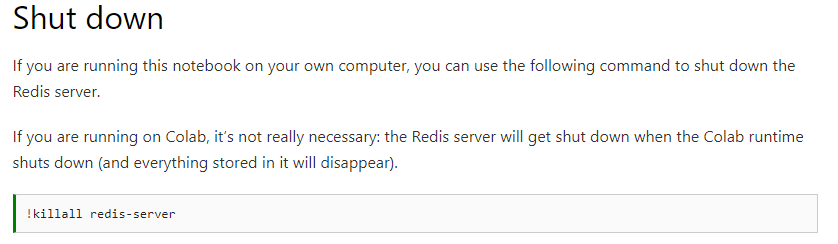

Nhưng với lệnh save thì redis sẽ lưu lại 1 file backup .rdb ngay tại thư mục của notebook <br> 
Sau đó thì chỉ cần tạo database là redis sẽ tự động restore dữ liệu

In [ ]:
# db.save()

In [ ]:
keys_t = db.keys()

Số lượng key trong database

In [ ]:
len(keys_t)

14501944

In [ ]:
keys_t

[b'edges:###0###Biconditional introduction',
 b'edges:###0###Amiga 500 Plus',
 b'edges:###0###Politics of Burkina Faso',
 b'Ahimsa',
 b'Animism',
 b'edges:###0###Bosphorus',
 b'Geography of Antarctica',
 b'edges:###4###Analcime',
 b'edges:###0###Aleister Crowley',
 b'edges:###1###Andrey Markov',
 b'edges:###0###Geography of Bulgaria',
 b'Amplitude modulation',
 b'Angst',
 b'Borneo',
 b'edges:###1###Adventure',
 b'Autism',
 b'edges:###4###Archbishop of Canterbury',
 b'edges:###0###Burgess Shale',
 b'Black Forest',
 b'Aruba',
 b'edges:###2###Asgard',
 b'Agamemnon',
 b'edges:###2###Archimedes',
 b'edges:###2###Telecommunications in Belgium',
 b'edges:###0###String Quartet No. 16 (Beethoven)',
 b'edges:###0###Allene',
 b'edges:###0###Ablative case',
 b'edges:###2###Bill Watterson',
 b'edges:###0###Brouwer fixed-point theorem',
 b'edges:###1###Transport in Armenia',
 b'edges:###3###Barter',
 b'edges:###3###Academy Award for Best Production Design',
 b'edges:###3###Barbados',
 b'Bactericide'

Ví dụ trực quan hơn về cấu trúc của database. Paragraph của entity Bluebox Lake

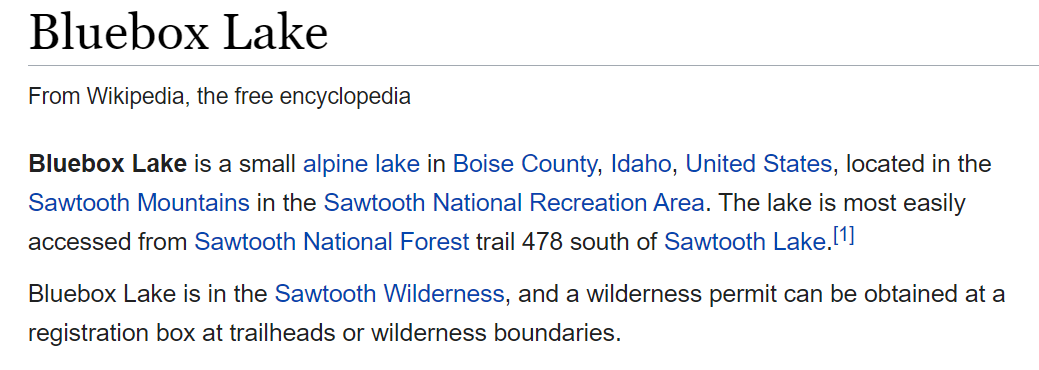

In [ ]:
db.lrange(b'Bluebox Lake',0,-1)
#Không biết sao nhưng mà nó lấy được có 2 câu à =)))))
#Có khi nó lấy paragraph đầu tiên

#Theo như mấy cái bên dưới thì nó lấy paragraph đầu thiệt

[b'Bluebox Lake is a small alpine lake in Boise County, Idaho, United States, located in the Sawtooth Mountains in the Sawtooth National Recreation Area.',
 b' The lake is most easily accessed from Sawtooth National Forest trail 478 south of Sawtooth Lake.']

Edges được hình thành tới các entity khác được nhắc đến trong sentence (text_with_link)<br>
Nếu entity có link đến những entity khác thì khi thêm edges:###X### (X là số thứ tự sentence chứa entity được link) trước entity đang được xét đến thì nó sẽ trả về list những entity được link, gồm: <br>
* **entity**###text_của_entity_được_link <br>
Ta có thể tiếp tục tìm dữ liệu thông qua **entity**

In [ ]:
#Trích xuất các entity được link trong câu 1
db.lrange(b'edges:###0###Bluebox Lake', 0, -1)

[b'alpine lake###alpine lake',
 b'Boise County, Idaho###Boise County',
 b'Idaho###Idaho',
 b'United States###United States',
 b'Sawtooth Range (Idaho)###Sawtooth Mountains',
 b'Sawtooth National Recreation Area###Sawtooth National Recreation Area']

In [ ]:
#Trích xuất các entity được link trong câu 2
db.lrange(b'edges:###1###Bluebox Lake', 0, -1)

[b'Sawtooth National Forest###Sawtooth National Forest',
 b'Sawtooth Lake###Sawtooth Lake']

In [ ]:
#Trích xuất các entity được link trong câu 3
db.lrange(b'edges:###2###Bluebox Lake', 0, -1)
#Trong paragraph đầu làm j có câu 3 =))))) nên nó rỗng là đúng r

[]

In [ ]:
#Thử trích xuất paragraphs từ entity Sawtooth National Recreation Area 
#trong câu 1 của entity Bluebox Lake
db.lrange(b'Sawtooth Range (Idaho)', 0, -1)

[b'The Sawtooth Range is a mountain range of the Rocky Mountains in central Idaho, United States, reaching a maximum elevation of 10751 ft at the summit of Thompson Peak.',
 b' It encompass an area of 678 sqmi spanning parts of Custer, Boise, Blaine, and Elmore counties, and is bordered to the east by the Sawtooth Valley.',
 b' Much of the mountain range is within the Sawtooth Wilderness, part of the Sawtooth National Recreation Area and Sawtooth National Forest.']

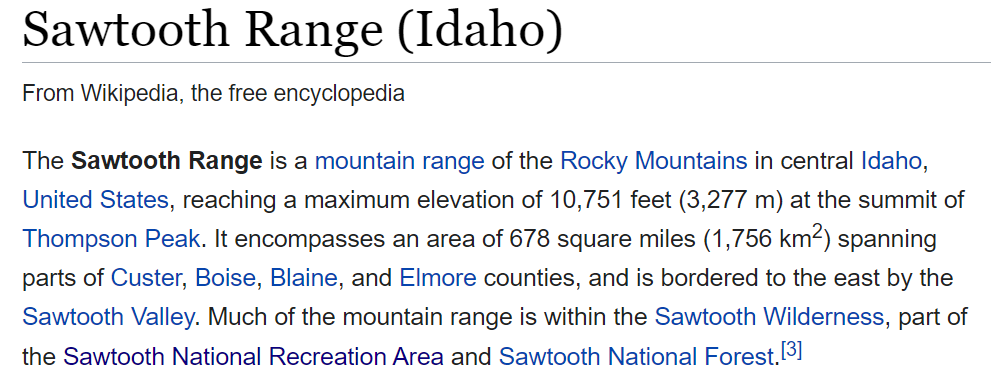

In [ ]:
db.lrange(b'edges###0###Sawtooth Range (Idaho)', 0, -1)
#Có vẻ như là chúng ta không thể tìm được edge được link cho 
#Sawtooth Range (Idaho) giống như entity Bluebox ban đầu
#Cũng đúng vì là theo như code thì chúng ta 
#chỉ thêm edge 1 lần cho những entity được link từ bộ dset wiki


#1 câu hỏi khác đó là nếu đúng như vậy thì khi nó xét tới Sawtooth Range (Idaho) 
#(giống như thêm key của Bluebox Lake), thì nó cũng phải thêm luôn key cho edges chứ nhỉ?

[]

Lý do vì sao lại đặt key theo dạng edges###X###title thì chắc phải tìm hiểu  thêm những hàm khác xem người ta xử lí ra sao

## process_train.py

In [ ]:
!pip install fuzzywuzzy==0.17.0

In [ ]:
# coding: utf-8
%cd /content/drive/MyDrive/Dataset/DS310_NLP/Dataset/CogQA-master/
# %pdb on
import json
import re
import numpy as np
import copy
from tqdm import tqdm 
# from pytorch_pretrained_bert.tokenization import whitespace_tokenize, BasicTokenizer, BertTokenizer
from redis import StrictRedis
from utils import fuzzy_find


# db = StrictRedis(host='localhost', port=6379, db=0)


with open('/content/drive/MyDrive/Dataset/DS310_NLP/Dataset/hotpot_dataset/hotpot_train_v1.1.json', 'r') as fin:
    train_set = json.load(fin)
print('Finish Reading! len = ', len(train_set))

/content/drive/MyDrive/Dataset/DS310_NLP/Dataset/CogQA-master


/usr/local/lib/python3.8/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


Finish Reading! len =  90447


In [ ]:
train_set[0]
# train_set[2]['context'][0]

In [ ]:
!pip install ujson

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 52 kB 1.0 MB/s 


In [ ]:
%cd /content/drive/MyDrive/Dataset/DS310_NLP/Dataset/CogQA-master/
from hotpot_evaluate_v1 import normalize_answer, f1_score
from fuzzywuzzy import fuzz, process as fuzzy_process

def fuzzy_retrive(entity, pool):
    if len(pool) > 100:
        # fullwiki, exact match
        # TODO: test ``entity (annotation)'' and find the most like one
        if pool.get(entity):
            return entity
        else:
            return None
    else:
        # distractor mode or use link in original wiki, no need to consider ``entity (annotation)''
        pool = pool if isinstance(pool, list) else pool.keys()
        f1max, ret = 0, None
        for t in pool:
            f1, precision, recall = f1_score(entity, t)
            if f1 > f1max:
                f1max, ret = f1, t
        return ret

def find_near_matches(w, sentence):
    ret = []
    max_ratio = 0
    t = 0
    for word in sentence.split():
        while sentence[t] != word[0]:
            t += 1
        score = (fuzz.ratio(w, word) + fuzz.partial_ratio(w, word)) / 2
        if score > max_ratio:
            max_ratio = score
            ret = [(t, t + len(word))]
        elif score == max_ratio:
            ret.append((t, t + len(word)))
        else:
            pass
        t += len(word)
    return ret if max_ratio > 85 else []     

/content/drive/MyDrive/Dataset/DS310_NLP/Dataset/CogQA-master


In [ ]:
db.lrange(b'edges:###0###Bluebox Lake',0,-1)

[b'alpine lake###alpine lake',
 b'Boise County, Idaho###Boise County',
 b'Idaho###Idaho',
 b'United States###United States',
 b'Sawtooth Range (Idaho)###Sawtooth Mountains',
 b'Sawtooth National Recreation Area###Sawtooth National Recreation Area']

In [ ]:
set([x.decode().split('###')[0] for x in db.lrange(b'edges:###0###Bluebox Lake', 0, -1)])

{'Boise County, Idaho',
 'Idaho',
 'Sawtooth National Recreation Area',
 'Sawtooth Range (Idaho)',
 'United States',
 'alpine lake'}

In [ ]:
# construct cognitive graph in training data    
from utils import judge_question_type
def find_fact_content(bundle, title, sen_num):
    for x in bundle['context']:
        if x[0] == title:
            return x[1][sen_num]

test = copy.deepcopy(train_set)

#Đổi thành 
# for bundle in tqdm( test[len(test) - 5: len(test)] ):   
  #để lấy được cái mẫu như phân tích bên dưới
for bundle in tqdm(test):
  #Trích xuất entity, là các title trong supporting facts của 1 mẫu
    entities = set([title for title, sen_num in bundle['supporting_facts']])
    #Q_edge là edge của question, tìm ra bằng cách sử dụng hàm fuzzy_find giữa entities trong supporting fact và câu hỏi gốc
    bundle['Q_edge'] = fuzzy_find(entities, bundle['question'])
    #Lấy ra kiểu câu hỏi, với 0 là câu hỏi dạng or, 1 là yes no, 2 là trả lời bth (có lẽ là entity?)
    question_type = judge_question_type(bundle['question'])
    for fact in bundle['supporting_facts']:  #Xét trên từng supporting fact
        try:
            title, sen_num = fact   #Lấy ra title và câu xuất hiện (câu) fact trong paragraph đó
            pool = set()
            #Khúc này chắc đang dò xem có edge nào trong paragraph ko á (đoán z)
            for i in range(sen_num + 1):
                name = 'edges:###{}###{}'.format(i, title)   #Lấy key của từng cái edge trong article (title) ra
                tmp = set([x.decode().split('###')[0] for x in db.lrange(name, 0, -1)])    #Lấy tên (title) của từng cái trong edge ra (lúc đầu là kiểu edge:###1###tên, lấy ra tên)
                pool |= tmp     # |= là inplace OR (nghĩa là giống như thêm tmp vào pool á mà)
            pool &= entities   # &= là inplace AND (nghĩa là lấy phần giao của pool và entities cho pool)
            stripped = [re.sub(r' \(.*?\)$', '', x) for x in pool] + ['yes', 'no']
            if bundle['answer'] not in stripped:   #Nếu câu hỏi đúng không nằm trong stripped
                if fuzz.ratio(re.sub(r'\(.*?\)$', '', title), bundle['answer']) > 80:   #Nếu tỉ lệ giống nhau giữa câu trả lời đúng và title > 80%
                    pool.add(title)
                else:
                    pool.add(bundle['answer'])
            if bundle['answer'] == 'yes' or bundle['answer'] == 'no' \
                    or (question_type > 0 and bundle['type'] == 'comparison'):
                pool.add(title)
            r = fuzzy_find(pool, find_fact_content(bundle, title, sen_num))
            fact.append(r)
        except IndexError as e: 
            print(bundle['_id'])
# with open('/content/drive/MyDrive/Dataset/DS310_NLP/Dataset/hotpot_dataset/hotpot_train_v1.1_refined.json', 'w') as fout:
#     json.dump(test, fout)


In [ ]:
with open('/content/drive/MyDrive/Dataset/DS310_NLP/Dataset/hotpot_dataset/hotpot_train_v1.1_refined.json', 'r') as fin:
    refine = json.load(fin)

In [ ]:
entities

{'Cricket at the 2017 Southeast Asian Games', 'Vietnam national cricket team'}

In [ ]:
bundle['question']

'Vietnam national cricket team will debut at what competitions at  Kinrara Oval'

In [ ]:
fuzzy_find(entities, bundle['question'])

[('Vietnam national cricket team', 'Vietnam national cricket team', 0, 29)]

In [ ]:
bundle

In [ ]:
#  tmp = set([x.decode().split('###')[0] for x in db.lrange(name, 0, -1)])
#Cái này trích ra 1 cái db.lrange(b'edges:###0###Bluebox Lake', 0, -1) là:
[b'alpine lake###alpine lake',
 b'Boise County, Idaho###Boise County',
 b'Idaho###Idaho',
 b'United States###United States',
 b'Sawtooth Range (Idaho)###Sawtooth Mountains',
 b'Sawtooth National Recreation Area###Sawtooth National Recreation Area'][4].decode().split('###')

['Sawtooth Range (Idaho)', 'Sawtooth Mountains']

In [ ]:
re.sub(r'\(.*?\)$', '', title)

'Cricket at the 2017 Southeast Asian Games'

In [ ]:
bundle['answer']

'2017 Southeast Asian Games'

In [ ]:
fuzz.ratio(re.sub(r'\(.*?\)$', '', title), bundle['answer'])

78

In [ ]:
fuzz.ratio('con cá','con cá chình điện')

52

In [ ]:
bundle #Bundle ban đầu là 1 mẫu trong train thôi, gồm những cái trong mẫu train (supporting fact, level, question, context, answer, _id, type, Q_edge)

#Nhưng mà qua cái bước xử lí thì nó thành refine

In [ ]:
bundle['supporting_facts'][2]

# a list. Each entry in the list is a list with two elements [title, sent_id], 
# where title denotes the title of the paragraph, and sent_id denotes the supporting fact's id (0-based) in this paragraph. 
# The test set does not have this key.


# Mỗi fact trong supporting_facts là list các [title, sent_id]; với sent_id là vị trí câu trong introductory para, title là title của article. 
# Trong tập text không có supporting_facts vì t đoán là nó dùng cho việc train System 2

['Cricket at the 2017 Southeast Asian Games',
 0,
 [('2017 Southeast Asian Games', '2017 Southeast Asian Games', 32, 58)]]

In [ ]:
bundle['context'][1]   
#A list, Each entry is a paragraph, which is represented as a list with two elements [title, sentences]

#Mỗi phần tử của context là [title, sentences]; với sentences là các câu trong introductory para của article có title là title

['Pickwick Cricket Club',
 ['Pickwick Cricket Club is a Barbados cricket club.',
  ' The club was founded on 23 November 1882, the second oldest cricket club in Barbados after Wanderers Cricket Club.',
  " The club's home from its foundation until 2005 was Kensington Oval in Bridgetown, the main venue for matches involving the Barbados national cricket team and the Barbados venue for Test cricket involving the West Indies cricket team.",
  ' The ground was built on land on Kensington Plantation leased by the club for a penny per annum.',
  ' Pickwick club developed Kensington Oval into the finest ground in Barbados and it soon replaced the Wanderers Ground and the Garrison Savanna as the venue for inter-colonial matches.']]

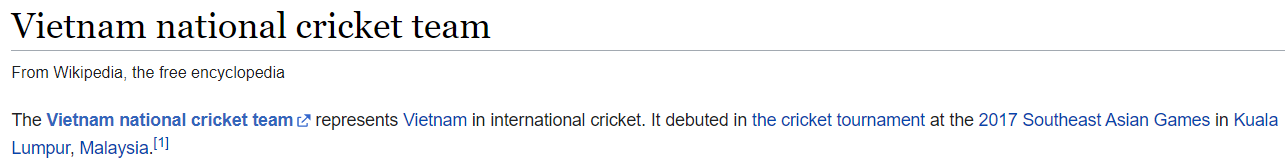

In [ ]:
entities #set([title for title, sen_num in bundle['supporting_facts']])   

# là list title trong supporting facts

{'Cricket at the 2017 Southeast Asian Games', 'Vietnam national cricket team'}

In [ ]:
bundle['question']

'Vietnam national cricket team will debut at what competitions at  Kinrara Oval'

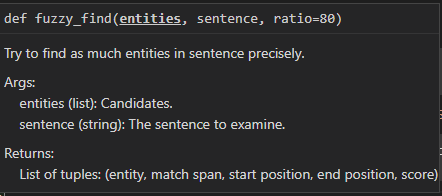

In [ ]:
bundle['question']

'Vietnam national cricket team will debut at what competitions at  Kinrara Oval'

In [ ]:
bundle['Q_edge']  # = fuzzy_find(entities, bundle['question'])

# input của fuzzy_find : entities (list): Candidates.
                      # sentence (string): The sentence to examine.

# output của fuzzy_find : (entity, match span, start position, end position, score)

[('Vietnam national cricket team', 'Vietnam national cricket team', 0, 29)]

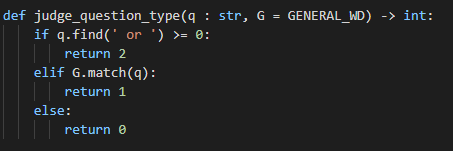

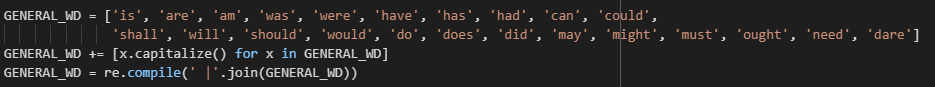

In [ ]:
GENERAL_WD

re.compile(r'is |are |am |was |were |have |has |had |can |could |shall |will |should |would |do |does |did |may |might |must |ought |need |dare |Is |Are |Am |Was |Were |Have |Has |Had |Can |Could |Shall |Will |Should |Would |Do |Does |Did |May |Might |Must |Ought |Need |Dare',
re.UNICODE)

In [ ]:
question_type = judge_question_type(bundle['question'])
question_type
#Nghĩa là nếu câu có 1 hoặc nhiều chữ 'or' thì là 2, trùng với những từ trong GENERAL_WD thì là 1 (Chắc là Yes No), trường hợp còn lại là 0 (Dạng trả lời entity)

0

In [ ]:
#title, sen_num = fact   sen_num là thứ tự câu trong introductory paragraph
train_set[len(train_set)-1]['supporting_facts'][0] #a fact

['Vietnam national cricket team', 0]

In [ ]:
train_set[len(train_set)-1]

In [ ]:
db.lrange(b'Asa Griggs Candler',0,-1)

[b'Asa Griggs Candler (December 30, 1851 \xe2\x80\x93 March 12, 1929) was an American business tycoon who founded the Coca-Cola Company.',
 b' He also served as the 41st Mayor of Atlanta, Georgia from 1916 to 1919.',
 b' Candler Field, the site of the present-day Hartsfield-Jackson Atlanta International Airport, was named after him, as is Candler Park in Atlanta.']

In [ ]:
i = 95
print('Type: {} \n Level: {} \n\n Q: {}\n\n A: {}'.format(refine[i]['type'], refine[i]['level'], refine[i]['question'], refine[i]['answer']))
print('\n SF:')
for j in refine[i]['supporting_facts']:
  print(j)
print('\nTrainset supporting facts:')
for j in train_set[i]['supporting_facts']:
  print(j)

Type: bridge 
 Level: medium 

 Q: Who invented the type of script used in autographs?

 A: the Sumerians

 SF:
['Autograph (Assyriology)', 0, [['Cuneiform script', 'cuneiform', 50, 59]]]
['Cuneiform script', 0, [['the Sumerians', 'the Sumerians', 84, 97]]]

Trainset supporting facts:
['Autograph (Assyriology)', 0]
['Cuneiform script', 0]


In [ ]:
train_set[94]['supporting_facts']

[['Rainbow Terrace', 0], ['Asa Griggs Candler', 0], ['Asa Griggs Candler', 1]]

In [ ]:
refine[-1]

# model.py

In [ ]:
!pip install pytorch-pretrained-bert
!pip install graphviz
!pip install torchviz
!pip install fuzzywuzzy==0.17.0
import numpy as np

In [ ]:
%cd /content/drive/MyDrive/Dataset/DS310_NLP/Dataset/CogQA-master/
import pytorch_pretrained_bert
from pytorch_pretrained_bert.modeling import (
    BertPreTrainedModel as PreTrainedBertModel, # The name was changed in the new versions of pytorch_pretrained_bert
    BertModel,
    BertLayerNorm,
    gelu,
    BertEncoder,
    BertPooler,
)
import torch
from torch import nn
from utils import (
    fuzzy_find,
    find_start_end_after_tokenized,
    find_start_end_before_tokenized,
    bundle_part_to_batch,
)
from pytorch_pretrained_bert.tokenization import (
    whitespace_tokenize,
    BasicTokenizer,
    BertTokenizer,
)
import re
import pdb

question_type == 0 thì nó sẽ dùng GCN cho CompareNets
<br> Còn question_type == 1 thì nó sẽ sử dụng both_net (ở dưới phần CognitiveGNN()), 2 thì là select_net (2 cái net này là MLP())
<br>
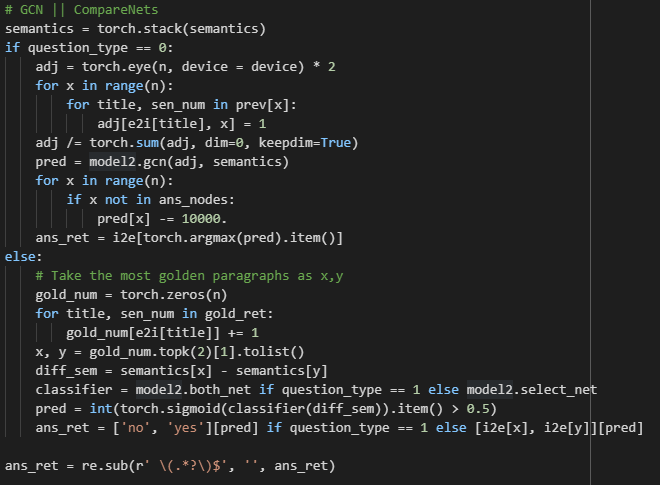

Và mấy cái model này nó kế thừa nhau các thứ <br>
Ví dụ GCN kế thừa cái MLP. CognitiveGNN kế thừa cả GCN và MLP
<br> Btw cái này ở trong **cogqa.py**

<br> Còn mấy cái _ret thì thấy ở trong hàm convert_question_to_samples_bundle của file **data.py**
<br>
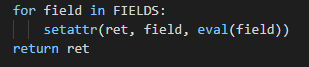

Cái GCN thì được nhắc đến:
<br>
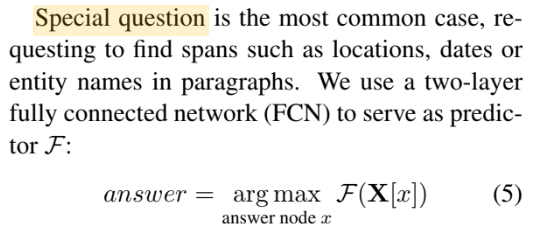

image.png <br>
Cái X[x] là các semantic vector á

image.png <br>
Semantics vector đc lưu trữ dạng stack

model2 là System 2 a.k.a CognitiveGNN

2 cái MLP được nhắc đến ở trong paper <br>
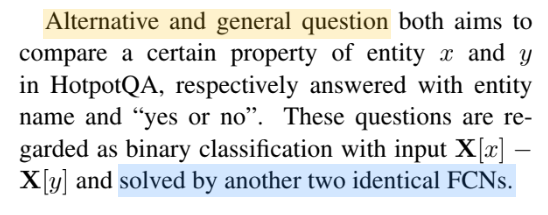

image.png <br> X[x] - X[y] là semantics[x] - semantics[y]

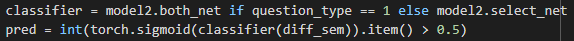
<br> Với both_net và select_net đều là MLP

In [ ]:
# classifier = self.both_net if bundle.question_type == 1 else self.select_net  với both_net là MLP, select_net cũng là MLP

class MLP(nn.Module):   #Multi-layer Perceptron   (Kiểu FCs)  # https://en.wikipedia.org/wiki/Multilayer_perceptron
    def __init__(self, input_sizes, dropout_prob=0.2, bias=False):
        super(MLP, self).__init__()   # https://stackoverflow.com/questions/576169/understanding-python-super-with-init-methods     # Nói chung super để nó kế thừa đc
        self.layers = nn.ModuleList()  # https://github.com/FrancescoSaverioZuppichini/Pytorch-how-and-when-to-use-Module-Sequential-ModuleList-and-ModuleDict
        for i in range(1, len(input_sizes)):  
            self.layers.append(nn.Linear(input_sizes[i - 1], input_sizes[i], bias=bias))  # torch.nn.Linear(in_features, out_features, bias=True, device=None, dtype=None)
        self.norm_layers = nn.ModuleList()
        if len(input_sizes) > 2:
            for i in range(1, len(input_sizes) - 1):
                self.norm_layers.append(nn.LayerNorm(input_sizes[i]))
        self.drop_out = nn.Dropout(p=dropout_prob)

    def forward(self, x):
        for i, layer in enumerate(self.layers):
            x = layer(self.drop_out(x))
            if i < len(self.layers) - 1:
                x = gelu(x)
                if len(self.norm_layers):
                    x = self.norm_layers[i](x)
        return x

# pred = self.gcn(bundle.adj.to(device), semantics)
class GCN(nn.Module):
    def init_weights(self, module):
        """ Initialize the weights.
        """
        if isinstance(module, (nn.Linear, nn.Embedding)):
            module.weight.data.normal_(mean=0.0, std=0.05)

    def __init__(self, input_size):
        super(GCN, self).__init__()
        self.diffusion = nn.Linear(input_size, input_size, bias=False)
        self.retained = nn.Linear(input_size, input_size, bias=False)
        self.predict = MLP(input_sizes=(input_size, input_size, 1))
        self.apply(self.init_weights)

    def forward(self, A, x):
        layer1_diffusion = A.t().mm(gelu(self.diffusion(x)))
        x = gelu(self.retained(x) + layer1_diffusion)
        layer2_diffusion = A.t().mm(gelu(self.diffusion(x)))
        x = gelu(self.retained(x) + layer2_diffusion)
        return self.predict(x).squeeze(-1)


class BertEmbeddingsPlus(nn.Module):
    """Construct the embeddings from word, position and token_type embeddings.
    """

    def __init__(self, config, max_sentence_type=30):
        super(BertEmbeddingsPlus, self).__init__()
        self.word_embeddings = nn.Embedding(config.vocab_size, config.hidden_size)
        self.position_embeddings = nn.Embedding(
            config.max_position_embeddings, config.hidden_size
        )
        self.token_type_embeddings = nn.Embedding(
            config.type_vocab_size, config.hidden_size
        )

        self.sentence_type_embeddings = nn.Embedding(
            max_sentence_type, config.hidden_size
        )
        # self.LayerNorm is not snake-cased to stick with TensorFlow model variable name and be able to load
        # any TensorFlow checkpoint file
        self.LayerNorm = BertLayerNorm(config.hidden_size, eps=1e-12)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)

    def forward(self, input_ids, token_type_ids=None):
        seq_length = input_ids.size(1)
        # seq_length = input_ids.size()[0]
        position_ids = torch.arange(
            seq_length, dtype=torch.long, device=input_ids.device
        )
        position_ids = position_ids.unsqueeze(0).expand_as(input_ids)
        if token_type_ids is None:
            token_type_ids = torch.zeros_like(input_ids)

        words_embeddings = self.word_embeddings(input_ids)
        position_embeddings = self.position_embeddings(position_ids)
        token_type_embeddings = self.token_type_embeddings((token_type_ids > 0).long())
        sentence_type_embeddings = self.sentence_type_embeddings(token_type_ids)

        embeddings = (
            words_embeddings
            + position_embeddings
            + token_type_embeddings
            + sentence_type_embeddings
        )
        embeddings = self.LayerNorm(embeddings)
        embeddings = self.dropout(embeddings)
        return embeddings


class BertModelPlus(BertModel):
    def __init__(self, config):
        super(BertModel, self).__init__(config)
        self.embeddings = BertEmbeddingsPlus(config)
        self.encoder = BertEncoder(config)
        self.pooler = BertPooler(config)
        self.apply(self.init_bert_weights)

    def forward(
        self, input_ids, token_type_ids=None, attention_mask=None, output_hidden=-4
    ):
        if attention_mask is None:
            attention_mask = torch.ones_like(input_ids)
        if token_type_ids is None:
            token_type_ids = torch.zeros_like(input_ids)

        # We create a 3D attention mask from a 2D tensor mask.
        # Sizes are [batch_size, 1, 1, to_seq_length]
        # So we can broadcast to [batch_size, num_heads, from_seq_length, to_seq_length]
        # this attention mask is more simple than the triangular masking of causal attention
        # used in OpenAI GPT, we just need to prepare the broadcast dimension here.
        extended_attention_mask = attention_mask.unsqueeze(1).unsqueeze(2)

        # Since attention_mask is 1.0 for positions we want to attend and 0.0 for
        # masked positions, this operation will create a tensor which is 0.0 for
        # positions we want to attend and -10000.0 for masked positions.
        # Since we are adding it to the raw scores before the softmax, this is
        # effectively the same as removing these entirely.
        extended_attention_mask = extended_attention_mask.to(
            dtype=next(self.parameters()).dtype
        )  # fp16 compatibility
        extended_attention_mask = (1.0 - extended_attention_mask) * -10000.0

        embedding_output = self.embeddings(input_ids, token_type_ids)
        encoded_layers = self.encoder(
            embedding_output, extended_attention_mask, output_all_encoded_layers=True
        )
        sequence_output = encoded_layers[-1]
        # pooled_output = self.pooler(sequence_output)
        encoded_layers, hidden_layers = (
            encoded_layers[-1],
            encoded_layers[output_hidden],
        )
        return encoded_layers, hidden_layers


class BertForMultiHopQuestionAnswering(PreTrainedBertModel):
    def __init__(self, config):
        super(BertForMultiHopQuestionAnswering, self).__init__(config)
        self.bert = BertModelPlus(config)
        self.qa_outputs = nn.Linear(config.hidden_size, 4)
        self.apply(self.init_bert_weights)

    def forward(
        self,
        input_ids,
        token_type_ids=None,
        attention_mask=None,
        sep_positions=None,
        hop_start_weights=None,
        hop_end_weights=None,
        ans_start_weights=None,
        ans_end_weights=None,
        B_starts=None,
        allow_limit=(0, 0),
    ):
        """ Extract spans by System 1.
        
        Args:
            input_ids (LongTensor): Token ids of word-pieces. (batch_size * max_length)
            token_type_ids (LongTensor): The A/B Segmentation in BERTs. (batch_size * max_length)
            attention_mask (LongTensor): Indicating whether the position is a token or padding. (batch_size * max_length)
            sep_positions (LongTensor): Positions of [SEP] tokens, mainly used in finding the num_sen of supporing facts. (batch_size * max_seps)
            hop_start_weights (Tensor): The ground truth of the probability of hop start positions. The weight of sample has been added on the ground truth. 
                (You can verify it by examining the gradient of binary cross entropy.)
            hop_end_weights ([Tensor]): The ground truth of the probability of hop end positions.
            ans_start_weights ([Tensor]): The ground truth of the probability of ans start positions.
            ans_end_weights ([Tensor]): The ground truth of the probability of ans end positions.
            B_starts (LongTensor): Start positions of sentence B.
            allow_limit (tuple, optional): An Offset for negative threshold. Defaults to (0, 0).
        
        Returns:
            [type]: [description]
        """
        batch_size = input_ids.size()[0]
        device = input_ids.get_device() if input_ids.is_cuda else torch.device("cpu")
        sequence_output, hidden_output = self.bert(
            input_ids, token_type_ids, attention_mask
        )
        semantics = hidden_output[:, 0]
        # Some shapes: sequence_output [batch_size, max_length, hidden_size], pooled_output [batch_size, hidden_size]
        if sep_positions is None:
            return semantics  # Only semantics, used in bundle forward
        else:
            max_sep = sep_positions.size()[-1]
        if max_sep == 0:
            empty = torch.zeros(batch_size, 0, dtype=torch.long, device=device)
            return (
                empty,
                empty,
                semantics,
                empty,
            )  # Only semantics, used in eval, the same ``empty'' variable is a mistake in general cases but simple

        # Predict spans
        logits = self.qa_outputs(sequence_output)
        hop_start_logits, hop_end_logits, ans_start_logits, ans_end_logits = logits.split(
            1, dim=-1
        )
        hop_start_logits = hop_start_logits.squeeze(-1)
        hop_end_logits = hop_end_logits.squeeze(-1)
        ans_start_logits = ans_start_logits.squeeze(-1)
        ans_end_logits = ans_end_logits.squeeze(-1)  # Shape: [batch_size, max_length]

        if hop_start_weights is not None:  # Train mode
            lgsf = torch.nn.LogSoftmax(
                dim=1
            )  # If there is no targeted span in the sentence, start_weights = end_weights = 0(vec)
            hop_start_loss = -torch.sum(
                hop_start_weights * lgsf(hop_start_logits), dim=-1
            )
            hop_end_loss = -torch.sum(hop_end_weights * lgsf(hop_end_logits), dim=-1)
            ans_start_loss = -torch.sum(
                ans_start_weights * lgsf(ans_start_logits), dim=-1
            )
            ans_end_loss = -torch.sum(ans_end_weights * lgsf(ans_end_logits), dim=-1)
            hop_loss = torch.mean((hop_start_loss + hop_end_loss)) / 2
            ans_loss = torch.mean((ans_start_loss + ans_end_loss)) / 2
        else:
            # In eval mode, find the exact top K spans.
            K_hop, K_ans = 3, 1
            hop_preds = torch.zeros(
                batch_size, K_hop, 3, dtype=torch.long, device=device
            )  # (start, end, sen_num)
            ans_preds = torch.zeros(
                batch_size, K_ans, 3, dtype=torch.long, device=device
            )
            ans_start_gap = torch.zeros(batch_size, device=device)
            for u, (start_logits, end_logits, preds, K, allow) in enumerate(
                (
                    (
                        hop_start_logits,
                        hop_end_logits,
                        hop_preds,
                        K_hop,
                        allow_limit[0],
                    ),
                    (
                        ans_start_logits,
                        ans_end_logits,
                        ans_preds,
                        K_ans,
                        allow_limit[1],
                    ),
                )
            ):
                for i in range(batch_size):
                    if sep_positions[i, 0] > 0:
                        values, indices = start_logits[i, B_starts[i] :].topk(K)
                        for k, index in enumerate(indices):
                            if values[k] <= start_logits[i, 0] - allow:  # not golden
                                if u == 1: # For ans spans
                                    ans_start_gap[i] = start_logits[i, 0] - values[k]
                                break
                            start = index + B_starts[i]
                            # find ending
                            for j, ending in enumerate(sep_positions[i]):
                                if ending > start or ending <= 0:
                                    break
                            if ending <= start:
                                break
                            ending = min(ending, start + 10)
                            end = torch.argmax(end_logits[i, start:ending]) + start
                            preds[i, k, 0] = start
                            preds[i, k, 1] = end
                            preds[i, k, 2] = j
        return (
            (hop_loss, ans_loss, semantics)
            if hop_start_weights is not None
            else (hop_preds, ans_preds, semantics, ans_start_gap)
        )


class CognitiveGNN(nn.Module):
    def __init__(self, hidden_size):
        super(CognitiveGNN, self).__init__()
        self.gcn = GCN(hidden_size)
        self.both_net = MLP((hidden_size, hidden_size, 1))
        self.select_net = MLP((hidden_size, hidden_size, 1))

    def forward(self, bundle, model, device):
        batch = bundle_part_to_batch(bundle)
        batch = tuple(t.to(device) for t in batch)
        hop_loss, ans_loss, semantics = model(
            *batch
        )  # Shape of semantics: [num_para, hidden_size]
        num_additional_nodes = len(bundle.additional_nodes)

        if num_additional_nodes > 0:
            max_length_additional = max([len(x) for x in bundle.additional_nodes])
            ids = torch.zeros(
                (num_additional_nodes, max_length_additional),
                dtype=torch.long,
                device=device,
            )
            segment_ids = torch.zeros(
                (num_additional_nodes, max_length_additional),
                dtype=torch.long,
                device=device,
            )
            input_mask = torch.zeros(
                (num_additional_nodes, max_length_additional),
                dtype=torch.long,
                device=device,
            )
            for i in range(num_additional_nodes):
                length = len(bundle.additional_nodes[i])
                ids[i, :length] = torch.tensor(
                    bundle.additional_nodes[i], dtype=torch.long
                )
                input_mask[i, :length] = 1
            additional_semantics = model(ids, segment_ids, input_mask)

            semantics = torch.cat((semantics, additional_semantics), dim=0)

        assert semantics.size()[0] == bundle.adj.size()[0]

        if bundle.question_type == 0:  # Wh-     #  Câu hỏi type 0 
            pred = self.gcn(bundle.adj.to(device), semantics)
            ce = torch.nn.CrossEntropyLoss()
            final_loss = ce(
                pred.unsqueeze(0),
                torch.tensor([bundle.answer_id], dtype=torch.long, device=device),
            )
        else:   # Câu hỏi type 1 2
            x, y, ans = bundle.answer_id
            ans = torch.tensor(ans, dtype=torch.float, device=device)
            diff_sem = semantics[x] - semantics[y]
            classifier = self.both_net if bundle.question_type == 1 else self.select_net
            final_loss = 0.2 * torch.nn.functional.binary_cross_entropy_with_logits(
                classifier(diff_sem).squeeze(-1), ans.to(device)
            )
        return hop_loss, ans_loss, final_loss

In [ ]:
hidden_size = 25 # Chọn đại

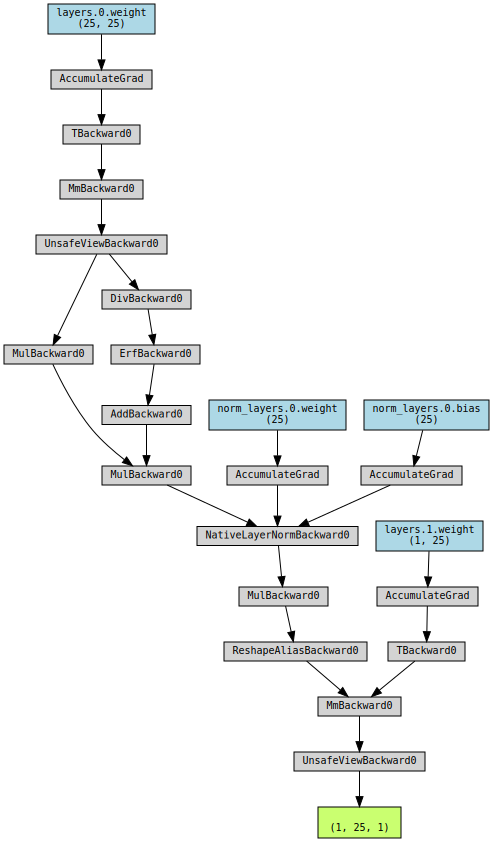

In [ ]:
from torchviz import make_dot
import torch

# MLP

# def __init__(self, input_sizes, dropout_prob=0.2, bias=False):

# def forward(self, x):


mlp_model = MLP(input_sizes = (hidden_size, hidden_size, 1))   # MLP((hidden_size, hidden_size, 1))

test_input = torch.rand(1, hidden_size, hidden_size)
y = mlp_model(test_input)  # def forward(self, x):

# make_dot(y, params=dict(mlp_model.named_parameters()), show_attrs=True, show_saved=True)
make_dot(y, params=dict(mlp_model.named_parameters()))

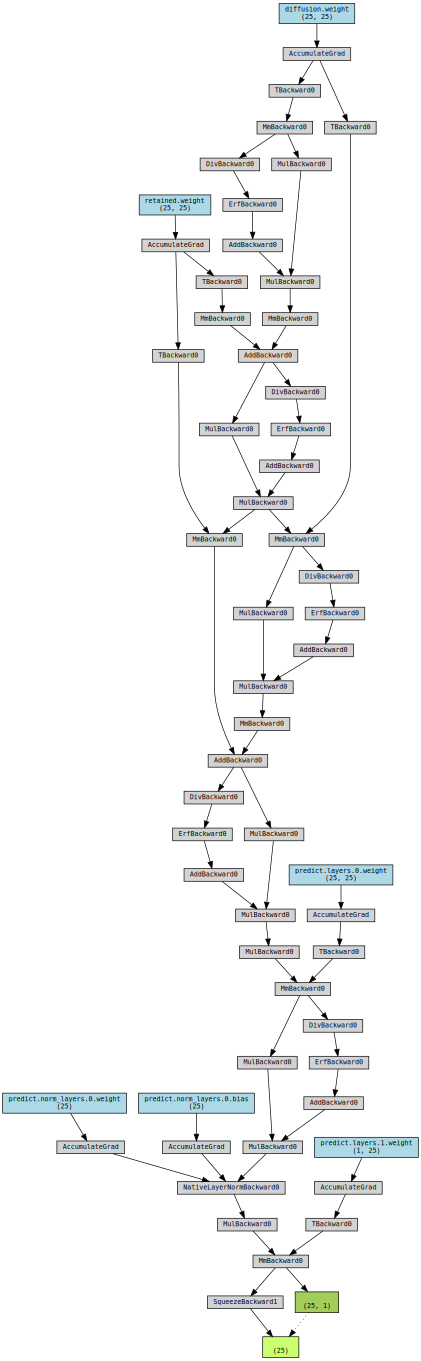

In [ ]:
# GCN

# def __init__(self, input_size):

# def forward(self, A, x):


GCN_model = GCN(input_size = (hidden_size))  # GCN(hidden_size)

semantic = torch.rand([hidden_size, hidden_size])  # Shape of semantics: [num_para, hidden_size]
A_test = torch.rand([hidden_size, hidden_size]) # Adjacency matrix

y = GCN_model(A_test, semantic)  # pred = self.gcn(bundle.adj.to(device), semantics)   #  def forward(self, A, x):  
make_dot(y, params=dict(GCN_model.named_parameters()))

In [ ]:
model = BertModelPlus.from_pretrained("bert-base-uncased")   # gọi ra để lấy config

100%|██████████| 407873900/407873900 [00:13<00:00, 29308611.82B/s]


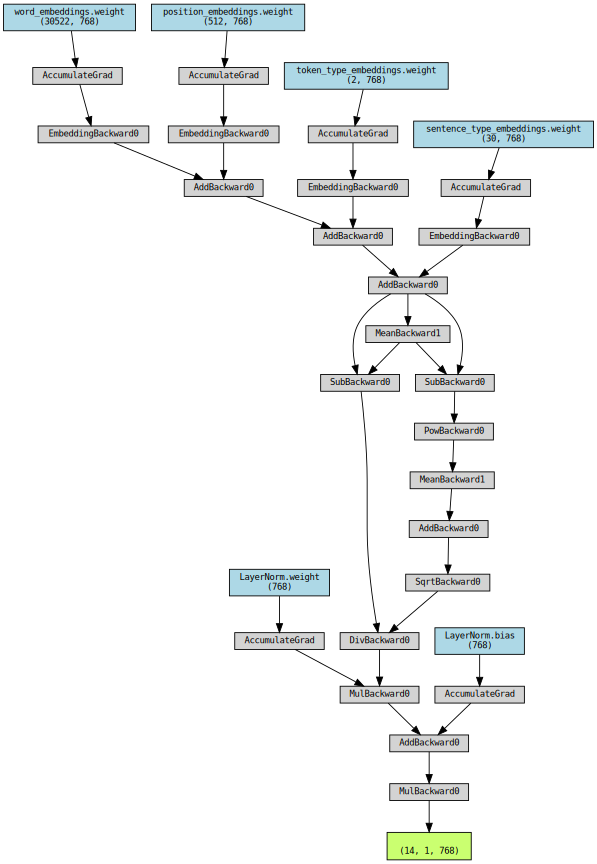

In [ ]:
# class BertEmbeddingsPlus(nn.Module):

# def __init__(self, config, max_sentence_type=30):
#     super(BertEmbeddingsPlus, self).__init__()
#     self.word_embeddings = nn.Embedding(config.vocab_size, config.hidden_size)

# config.type_vocab_size

# def forward(self, input_ids, token_type_ids=None):

# config gồm vocab_size, type_vocab_size, max_position_embeddings, hidden_dropout_prob và hidden_size

# class config():  # chọn đại chứ cũng hên xui =)))))
#   vocab_size = 1000
#   hidden_size = 25
#   type_vocab_size = 10
#   max_position_embeddings = 15
#   hidden_dropout_prob = 0.5

# cf = config()
cf = model.config 
bert_embedding = BertEmbeddingsPlus(cf)


BERT_MODEL = "bert-base-uncased"  #  https://huggingface.co/models?search=bert
tokenizer = BertTokenizer.from_pretrained(BERT_MODEL, do_lower_case=True)

sentence = 'hello, this is my pussy cat. He is very cute and kind'

tokenized = tokenizer.tokenize(sentence)
inp_ids = tokenizer.convert_tokens_to_ids(tokenized)
inp_ids = np.array(inp_ids).reshape(-1, 1)
inp_ids = torch.LongTensor(inp_ids)

# inp_ids = torch.zeros((30, 13), dtype = torch.long)  # Chọn đại chứ đéo biết sao =))))
# ids_tensor = torch.zeros((num_samples, max_length), dtype = torch.long, device = device)
y = bert_embedding(inp_ids, token_type_ids = None)
make_dot(y, params=dict(bert_embedding.named_parameters()))

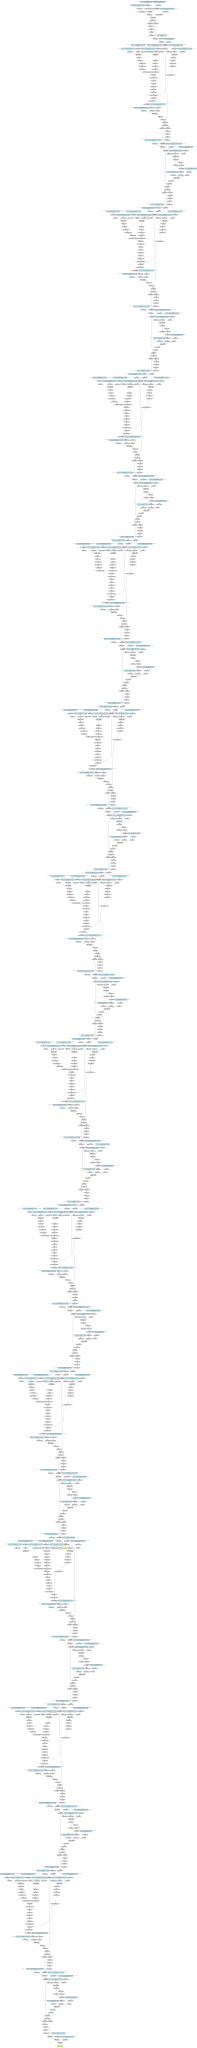

In [ ]:
# class BertModelPlus(BertModel):

# def forward( self, input_ids, token_type_ids=None, attention_mask=None, output_hidden=-4)

bert_plus = BertModelPlus(model.config)

BERT_MODEL = "bert-base-uncased"  #  https://huggingface.co/models?search=bert
tokenizer = BertTokenizer.from_pretrained(BERT_MODEL, do_lower_case=True)

sentence = 'hello, this is my pussy cat. He is very cute and kind'

tokenized = tokenizer.tokenize(sentence)
inp_ids = tokenizer.convert_tokens_to_ids(tokenized)
inp_ids = np.array(inp_ids).reshape(-1, 1)
inp_ids = torch.LongTensor(inp_ids)

y = bert_plus(inp_ids, token_type_ids = None)
make_dot(y, params=dict(bert_plus.named_parameters()))

In [ ]:
#  class BertForMultiHopQuestionAnswering(PreTrainedBertModel):

# def __init__(self, config):

# def forward(
#     self,
#     input_ids,
#     token_type_ids=None,
#     attention_mask=None,
#     sep_positions=None,
#     hop_start_weights=None,
#     hop_end_weights=None,
#     ans_start_weights=None,
#     ans_end_weights=None,
#     B_starts=None,
#     allow_limit=(0, 0),
# ):

bert_mh = BertForMultiHopQuestionAnswering(model.config)

BERT_MODEL = "bert-base-uncased"  #  https://huggingface.co/models?search=bert
tokenizer = BertTokenizer.from_pretrained(BERT_MODEL, do_lower_case=True)

sentence = 'hello, this is my pussy cat. He is very cute and kind'

tokenized = tokenizer.tokenize(sentence)
inp_ids = tokenizer.convert_tokens_to_ids(tokenized)
inp_ids = np.array(inp_ids).reshape(-1, 1)
inp_ids = torch.LongTensor(inp_ids)

y = bert_mh(inp_ids, token_type_ids = None)
make_dot(y, params=dict(bert_mh.named_parameters()))

In [ ]:
# class CognitiveGNN(nn.Module):

# def __init__(self, hidden_size):

# def forward(self, bundle, model, device):

cog_gnn = CognitiveGNN(hidden_size)

cog_gnn.select_net
# y = cog_gnn(check_refine[0:2], model, 'cpu')

MLP(
  (layers): ModuleList(
    (0): Linear(in_features=25, out_features=25, bias=False)
    (1): Linear(in_features=25, out_features=1, bias=False)
  )
  (norm_layers): ModuleList(
    (0): LayerNorm((25,), eps=1e-05, elementwise_affine=True)
  )
  (drop_out): Dropout(p=0.2, inplace=False)
)

In [ ]:
if __name__ == "__main__":
    BERT_MODEL = "bert-base-uncased"
    # BERT_MODEL = "bert-base-multilingual-cased"   #  https://huggingface.co/models?search=bert
    tokenizer = BertTokenizer.from_pretrained(BERT_MODEL, do_lower_case=True)
    orig_text = "".join(
        [
            "Theatre Centre is a UK-based theatre company touring new plays for young audiences aged 4 to 18, founded in 1953 by Brian Way, the company has developed plays by writers including which British writer, dub poet and Rastafarian?",
            " It is the largest urban not-for-profit theatre company in the country and the largest in Western Canada, with productions taking place at the 650-seat Stanley Industrial Alliance Stage, the 440-seat Granville Island Stage, the 250-seat Goldcorp Stage at the BMO Theatre Centre, and on tour around the province.",
        ]
    )
    tokenized_text = tokenizer.tokenize(orig_text)
    tokenized_text


100%|██████████| 995526/995526 [00:00<00:00, 7064253.03B/s]


#data.py

In [ ]:
with open('/content/drive/MyDrive/Dataset/DS310_NLP/Dataset/hotpot_dataset/hotpot_train_v1.1_refined.json', 'r') as fin:
    refine = json.load(fin)

In [ ]:
%cd /content/drive/MyDrive/Dataset/DS310_NLP/Dataset/CogQA-master/
import re
import json
from tqdm import tqdm, trange
import pdb
import random
from collections import namedtuple
import numpy as np
import copy
import traceback
import torch
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from pytorch_pretrained_bert.tokenization import whitespace_tokenize, BasicTokenizer, BertTokenizer
from pytorch_pretrained_bert.modeling import BertForQuestionAnswering
from pytorch_pretrained_bert.file_utils import PYTORCH_PRETRAINED_BERT_CACHE
from pytorch_pretrained_bert.optimization import BertAdam
from model import BertForMultiHopQuestionAnswering, CognitiveGNN
from utils import warmup_linear, find_start_end_after_tokenized, find_start_end_before_tokenized, bundle_part_to_batch, fuzzy_retrieve, WindowMean, fuzz

/content/drive/MyDrive/Dataset/DS310_NLP/Dataset/CogQA-master


In [ ]:
class Bundle(object):
    """The structure to contain all data for training. 
    
    A flexible class. The properties are defined in FIELDS and dynamically added by capturing variables with the same names at runtime.
    """
    pass

FIELDS = ['ids', 'hop_start_weights', 'hop_end_weights', 'ans_start_weights', 'ans_end_weights', 'segment_ids', 'sep_positions',
     'additional_nodes', 'adj', 'answer_id', 'question_type', '_id']


# Judge question type with interrogative words
GENERAL_WD = ['is', 'are', 'am', 'was', 'were', 'have', 'has', 'had', 'can', 'could', 
              'shall', 'will', 'should', 'would', 'do', 'does', 'did', 'may', 'might', 'must', 'ought', 'need', 'dare']
GENERAL_WD += [x.capitalize() for x in GENERAL_WD]
GENERAL_WD = re.compile(' |'.join(GENERAL_WD))
def judge_question_type(q : str, G = GENERAL_WD) -> int:
    if q.find(' or ') >= 0:
        return 2 
    elif G.match(q):
        return 1
    else:
        return 0

In [ ]:
print(judge_question_type('what is the definition of deep learning?'))
print(judge_question_type('what is bigger, elephant or ant?'))
print(judge_question_type('who is the president of USA?'))

0
2
0


In [ ]:
def improve_question_type_and_answer(data, e2i):
    '''Improve the result of the judgement of question type in training data with other information.
    
    If the question is a special question(type 0), answer_id is the index of final answer node. Otherwise answer_ids are
    the indices of two compared nodes and the result of comparison(0 / 1).
    This part is not very important to the overall results, but avoids Runtime Errors in rare cases.
    
    Args:
        data (Json): Refined distractor-setting samples.
        e2i (dict): entity2index dict.
    
    Returns:
        (int, int or (int, int, 0 / 1), string): question_type, answer_id and answer_entity.
    '''
    question_type = judge_question_type(data['question'])
    # fix judgement by answer
    if data['answer'] == 'yes' or data['answer'] == 'no':
        question_type = 1
        answer_entity = data['answer']
    else:
        # check whether the answer can be extracted as a span
        answer_entity = fuzzy_retrieve(data['answer'], e2i, 'distractor', 80)
        if answer_entity is None:
            raise ValueError('Cannot find answer: {}'.format(data['answer']))
    
    if question_type == 0:
        answer_id = e2i[answer_entity]
    elif len(data['Q_edge']) != 2:
        if question_type == 1:
            raise ValueError('There must be 2 entities in "Q_edge" for type 1 question.')
        elif question_type == 2: # Judgement error, should be type 0
            question_type = 0
            answer_id = e2i[answer_entity]
    else:
        answer_id = [e2i[data['Q_edge'][0][0]], e2i[data['Q_edge'][1][0]]] # compared nodes
        if question_type == 1:
            answer_id.append(int(data['answer'] == 'yes'))
        elif question_type == 2:
            if data['answer'] == data['Q_edge'][0][1]:
                answer_id.append(0)
            elif data['answer'] == data['Q_edge'][1][1]:
                answer_id.append(1)
            else: # cannot exactly match an option
                score = (fuzz.partial_ratio(data['answer'], data['Q_edge'][0][1]), fuzz.partial_ratio(data['answer'], data['Q_edge'][1][1]))
                if score[0] < 50 and score[1] < 50:
                    raise ValueError('There is no exact match in selecting question. answer: {}'.format(data['answer']))
                else:
                    answer_id.append(0 if score[0] > score[1] else 1)
    return question_type, answer_id, answer_entity

In [ ]:
# improve_question_type_and_answer(refine[0], )

In [ ]:
def convert_question_to_samples_bundle(tokenizer, data: 'Json refined', neg = 2):
    '''Make training samples.
    
    Convert distractor-setting samples(question + 10 paragraphs + answer + supporting facts) to bundles.
    
    Args:
        tokenizer (BertTokenizer): BERT Tokenizer to transform sentences to a list of word pieces.
        data (Json): Refined distractor-setting samples with gold-only cognitive graphs. 
        neg (int, optional): Defaults to 2. Negative answer nodes to add in every sample.
    
    Raises:
        ValueError: Invalid question type. 

    Returns:
        Bundle: A bundle containing 10 separate samples(including gold and negative samples).
    '''

    context = dict(data['context']) # all the entities in 10 paragraphs
    gold_sentences_set = dict([((para, sen), edges) for para, sen, edges in data['supporting_facts']]) 
    e2i, i2e = {}, [] # entity2index, index2entity
    for entity, sens in context.items():
        e2i[entity] = len(i2e)
        i2e.append(entity)
    clues = [[]] * len(i2e) # pre-extracted clues

    ids, hop_start_weights, hop_end_weights, ans_start_weights, ans_end_weights, segment_ids, sep_positions, additional_nodes = [], [], [], [], [], [], [], []
    tokenized_question = ['[CLS]'] + tokenizer.tokenize(data['question']) + ['[SEP]']

    # Extract clues for entities in the gold-only cogntive graph
    for entity_x, sen, edges in data['supporting_facts']:
        for entity_y, _, _, _ in edges:
            if entity_y not in e2i: # entity y must be the answer
                assert data['answer'] == entity_y
                e2i[entity_y] = len(i2e)
                i2e.append(entity_y)
                clues.append([])
            if entity_x != entity_y:
                y = e2i[entity_y]
                clues[y] = clues[y] + tokenizer.tokenize(context[entity_x][sen]) + ['[SEP]']
    
    question_type, answer_id, answer_entity = improve_question_type_and_answer(data, e2i)
    
    # Construct training samples
    for entity, para in context.items():
        num_hop, num_ans = 0, 0
        tokenized_all = tokenized_question + clues[e2i[entity]]
        if len(tokenized_all) > 512: # BERT-base accepts at most 512 tokens
            tokenized_all = tokenized_all[:512]
            print('CLUES TOO LONG, id: {}'.format(data['_id']))
        # initialize a sample for ``entity''
        sep_position = [] 
        segment_id = [0] * len(tokenized_all)
        hop_start_weight = [0] * len(tokenized_all)
        hop_end_weight = [0] * len(tokenized_all)
        ans_start_weight = [0] * len(tokenized_all)
        ans_end_weight = [0] * len(tokenized_all)

        for sen_num, sen in enumerate(para):
            tokenized_sen = tokenizer.tokenize(sen) + ['[SEP]']
            if len(tokenized_all) + len(tokenized_sen) > 512 or sen_num > 15:
                break
            tokenized_all += tokenized_sen
            segment_id += [sen_num + 1] * len(tokenized_sen)
            sep_position.append(len(tokenized_all) - 1)
            hs_weight = [0] * len(tokenized_sen)
            he_weight = [0] * len(tokenized_sen)
            as_weight = [0] * len(tokenized_sen)
            ae_weight = [0] * len(tokenized_sen)
            if (entity, sen_num) in gold_sentences_set:
                edges = gold_sentences_set[(entity, sen_num)]
                intervals = find_start_end_after_tokenized(tokenizer, tokenized_sen,
                    [matched  for _, matched, _, _ in edges])
                for j, (l, r) in enumerate(intervals):
                    if edges[j][0] == answer_entity or question_type > 0: # successive node edges[j][0] is answer node
                        as_weight[l] = ae_weight[r] = 1
                        num_ans += 1
                    else: # edges[j][0] is next-hop node
                        hs_weight[l] = he_weight[r] = 1
                        num_hop += 1
            hop_start_weight += hs_weight
            hop_end_weight += he_weight
            ans_start_weight += as_weight
            ans_end_weight += ae_weight
            
        assert len(tokenized_all) <= 512
        # if entity is a negative node, train negative threshold at [CLS] 
        if 1 not in hop_start_weight:
            hop_start_weight[0] = 0.1
        if 1 not in ans_start_weight:
            ans_start_weight[0] = 0.1

        ids.append(tokenizer.convert_tokens_to_ids(tokenized_all))
        sep_positions.append(sep_position)
        segment_ids.append(segment_id)
        hop_start_weights.append(hop_start_weight)
        hop_end_weights.append(hop_end_weight)
        ans_start_weights.append(ans_start_weight)
        ans_end_weights.append(ans_end_weight)

    # Construct negative answer nodes for task #2(answer node prediction)
    n = len(context)
    edges_in_bundle = []
    if question_type == 0:
        # find all edges and prepare forbidden set(containing answer) for negative sampling
        forbidden = set([])
        for para, sen, edges in data['supporting_facts']:
            for x, matched, l, r in edges:
                edges_in_bundle.append((e2i[para], e2i[x]))
                if x == answer_entity:
                    forbidden.add((para, sen))
        if answer_entity not in context and answer_entity in e2i:
            n += 1
            tokenized_all = tokenized_question + clues[e2i[answer_entity]]
            if len(tokenized_all) > 512:
                tokenized_all = tokenized_all[:512]
                print('ANSWER TOO LONG! id: {}'.format(data['_id']))
            additional_nodes.append(tokenizer.convert_tokens_to_ids(tokenized_all))

        for i in range(neg):
            # build negative answer node n+i
            father_para = random.choice(list(context.keys()))
            father_sen = random.randrange(len(context[father_para]))
            if (father_para, father_sen) in forbidden:
                father_para = random.choice(list(context.keys()))
                father_sen = random.randrange(len(context[father_para]))
            if (father_para, father_sen) in forbidden:
                neg -= 1
                continue
            tokenized_all = tokenized_question + tokenizer.tokenize(context[father_para][father_sen]) + ['[SEP]']
            if len(tokenized_all) > 512:
                tokenized_all = tokenized_all[:512]
                print('NEG TOO LONG! id: {}'.format(data['_id']))
            additional_nodes.append(tokenizer.convert_tokens_to_ids(tokenized_all))
            edges_in_bundle.append((e2i[father_para], n))
            n += 1

    if question_type >= 1:
        for para, sen, edges in data['supporting_facts']:
            for x, matched, l, r in edges:
                if e2i[para] < n and  e2i[x] < n:
                    edges_in_bundle.append((e2i[para], e2i[x]))
                    
    assert n == len(additional_nodes) + len(context)
    adj = torch.eye(n) * 2
    for x, y in edges_in_bundle:
        adj[x, y] = 1
    adj /= torch.sum(adj, dim=0, keepdim=True)

    _id = data['_id']
    ret = Bundle()
    for field in FIELDS:
        setattr(ret, field, eval(field))
    return ret

In [ ]:
BERT_MODEL = "bert-base-uncased"  #  https://huggingface.co/models?search=bert
tokenizer = BertTokenizer.from_pretrained(BERT_MODEL, do_lower_case=True)

bundle_test = convert_question_to_samples_bundle(tokenizer, data = refine[0])

In [ ]:
bundle_test.adj

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])

In [ ]:

    
def homebrew_data_loader(bundles, mode : 'bundle or tensors' = 'tensors', batch_size = 8):
    '''Return a generator like DataLoader in pytorch
    
    Different data are fed in task #1 and #2. In task #1, steps for different entities are decoupled into 10 samples
    and can be randomly shuffled. But in task #2, inputs must be whole graphs. 
    
    Args:
        bundles (list): List of bundles for questions.
        mode (string, optional): Defaults to 'tensors'. 'tensors' represents dataloader for task #1,
            'bundle' represents dataloader for task #2.
        batch_size (int, optional): Defaults to 8. 
    
    Raises:
        ValueError: Invalid mode
    
    Returns:
        (int, Generator): number of batches and a generator to generate batches.
    '''

    if mode == 'bundle':
        random.shuffle(bundles)
        def gen():
            for bundle in bundles:
                yield bundle
        return len(bundles), gen()
    elif mode == 'tensors':
        all_bundle = Bundle()
        for field in FIELDS[:7]:
            t = []
            setattr(all_bundle, field, t)
            for bundle in bundles:
                t.extend(getattr(bundle, field))
        n = len(t)
        # random shuffle
        orders = np.random.permutation(n)
        for field in FIELDS[:7]:
            t = getattr(all_bundle, field)
            setattr(all_bundle, field, [t[x] for x in orders])
        
        num_batch = (n - 1) // batch_size + 1
        def gen():
            for batch_num in range(num_batch):
                l, r = batch_num * batch_size, min((batch_num + 1) * batch_size, n)
                yield bundle_part_to_batch(all_bundle, l, r)
        return num_batch, gen()
    else:
        raise ValueError('mode must be "bundle" or "tensors"!')
        

# cogqa.py

In [ ]:
import re
import json
from pytorch_pretrained_bert.tokenization import whitespace_tokenize, BasicTokenizer, BertTokenizer
from pytorch_pretrained_bert.modeling import BertForQuestionAnswering
from model import BertForMultiHopQuestionAnswering, CognitiveGNN
from torch.optim import Adam
from tqdm import tqdm, trange
from pytorch_pretrained_bert.file_utils import PYTORCH_PRETRAINED_BERT_CACHE
import pdb
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from pytorch_pretrained_bert.optimization import BertAdam
from utils import warmup_linear, find_start_end_after_tokenized, find_start_end_before_tokenized, bundle_part_to_batch, judge_question_type, fuzzy_retrieve, WindowMean, get_context_fullwiki
import random
from collections import namedtuple
import numpy as np
import copy

In [ ]:
def cognitive_graph_propagate(tokenizer, data: 'Json eval(Context as pool)', model1, model2, device, setting:'distractor / fullwiki' = 'fullwiki', max_new_nodes = 5):
    """Answer the question in ``data'' by trained CogQA model.
    
    Args:
        tokenizer (Tokenizer): Word-Piece tokenizer.
        data (Json): Unrefined.
        model1 (nn.Module): System 1 model.
        model2 (nn.Module): System 2 model.
        device (torch.device): Selected device.
        setting (string, optional): 'distractor / fullwiki'. Defaults to 'fullwiki'.
        max_new_nodes (int, optional): Maximum number of new nodes in cognitive graph. Defaults to 5.
    
    Returns:
        tuple: (gold_ret, ans_ret, graph_ret, ans_nodes_ret)
    """
    context = dict(data['context'])
    e2i = dict([(entity, id) for id, entity in enumerate(context.keys())])
    n = len(context)
    i2e = [''] * n
    for k, v in e2i.items():
        i2e[v] = k  
    prev = [[] for i in range(n)] # elements: (title, sen_num)
    queue = range(n) 
    semantics = [None] * n   # Semantic vectors

    tokenized_question = ['[CLS]'] + tokenizer.tokenize(data['question']) + ['[SEP]']

    def construct_infer_batch(queue):
        """Construct next batch (frontier nodes to visit).
        
        Args:
            queue (list): A queue containing frontier nodes.
        
        Returns:
            tuple: A batch of inputs
        """
        ids, sep_positions, segment_ids, tokenized_alls, B_starts = [], [], [], [], []
        max_length, max_seps, num_samples = 0, 0, len(queue)
        for x in queue:
            tokenized_all = copy.copy(tokenized_question)
            for title, sen_num in prev[x]:
                tokenized_all += tokenizer.tokenize(context[title][sen_num]) + ['[SEP]']
            if len(tokenized_all) > 512:
                tokenized_all = tokenized_all[:512]
                print('PREV TOO LONG, id: {}'.format(data['_id']))
            segment_id = [0] * len(tokenized_all)
            sep_position = [] 
            B_starts.append(len(tokenized_all))
            for sen_num, sen in enumerate(context[i2e[x]]):
                tokenized_sen = tokenizer.tokenize(sen) + ['[SEP]']
                if len(tokenized_all) + len(tokenized_sen) > 512 or sen_num > 15:
                    break
                tokenized_all += tokenized_sen
                segment_id += [sen_num + 1] * len(tokenized_sen)
                sep_position.append(len(tokenized_all) - 1)
            max_length = max(max_length, len(tokenized_all))
            max_seps = max(max_seps, len(sep_position))
            tokenized_alls.append(tokenized_all)
            ids.append(tokenizer.convert_tokens_to_ids(tokenized_all))
            sep_positions.append(sep_position)
            segment_ids.append(segment_id)

        ids_tensor = torch.zeros((num_samples, max_length), dtype = torch.long, device = device)
        sep_positions_tensor = torch.zeros((num_samples, max_seps), dtype = torch.long, device = device)
        segment_ids_tensor = torch.zeros((num_samples, max_length), dtype = torch.long, device = device)
        input_mask = torch.zeros((num_samples, max_length), dtype = torch.long, device = device)
        B_starts = torch.tensor(B_starts, dtype = torch.long, device = device)
        for i in range(num_samples):
            length = len(ids[i])
            ids_tensor[i, :length] = torch.tensor(ids[i], dtype = torch.long)
            sep_positions_tensor[i, :len(sep_positions[i])] = torch.tensor(sep_positions[i], dtype = torch.long)
            segment_ids_tensor[i, :length] = torch.tensor(segment_ids[i], dtype = torch.long)
            input_mask[i, :length] = 1
        return ids_tensor, segment_ids_tensor, input_mask, sep_positions_tensor, tokenized_alls, B_starts
    
    gold_ret, ans_nodes = set([]), set([])
    allow_limit = [0, 0]
    while len(queue) > 0:   # Nếu như còn frontier node thì tiếp tục lặp
        # visit all nodes in the frontier queue
        ids, segment_ids, input_mask, sep_positions, tokenized_alls, B_starts = construct_infer_batch(queue)
        hop_preds, ans_preds, semantics_preds, no_ans_logits = model1(ids, segment_ids, input_mask, sep_positions,
            None, None, None, None, 
            B_starts, allow_limit)   # Lấy các thông số cần thiết cho BERT cũng như là dự đoán semantic vectors của frontier node
        new_queue = []  # Này tạo queue thêm frontier node mới
        for i, x in enumerate(queue):
            semantics[x] = semantics_preds[i]  
            # for hop spans
            for k in range(hop_preds.size()[1]):
                l, r, j = hop_preds[i, k]
                j = j.item()
                if l == 0:
                    break
                gold_ret.add((i2e[x], j)) # supporting facts
                orig_text = context[i2e[x]][j]
                pred_slice = tokenized_alls[i][l : r + 1]
                l, r = find_start_end_before_tokenized(orig_text, [pred_slice])[0]
                if l == r == 0:
                    continue    
                recovered_matched = orig_text[l: r]
                pool = context if setting == 'distractor' else (i2e[x], j)
                matched = fuzzy_retrieve(recovered_matched, pool, setting)    
                if matched is not None:
                    if setting == 'fullwiki' and matched not in e2i and n < 10 + max_new_nodes:
                        context_new = get_context_fullwiki(matched)
                        if len(context_new) > 0: # cannot resovle redirection
                            # create new nodes in the cognitive graph
                            context[matched] = context_new
                            prev.append([])
                            semantics.append(None)
                            e2i[matched] = n
                            i2e.append(matched)
                            n += 1
                    if matched in e2i and e2i[matched] != x:
                        y = e2i[matched]
                        if y not in new_queue and (i2e[x], j) not in prev[y]:
                            # new edge means new clues! update the successor as frontier nodes.
                            new_queue.append(y)
                            prev[y].append(((i2e[x], j)))
            # for ans spans
            for k in range(ans_preds.size()[1]):
                l, r, j = ans_preds[i, k]
                j = j.item()
                if l == 0:
                    break
                gold_ret.add((i2e[x], j))
                orig_text = context[i2e[x]][j]
                pred_slice = tokenized_alls[i][l : r + 1]
                l, r = find_start_end_before_tokenized(orig_text, [pred_slice])[0]
                if l == r == 0:
                    continue    
                recovered_matched = orig_text[l: r]
                matched = fuzzy_retrieve(recovered_matched, context, 'distractor', threshold=70)
                if matched is not None:
                    y = e2i[matched]
                    ans_nodes.add(y)
                    if (i2e[x], j) not in prev[y]:
                        prev[y].append(((i2e[x], j)))
                elif n < 10 + max_new_nodes:
                    context[recovered_matched] = []
                    e2i[recovered_matched] = n
                    i2e.append(recovered_matched)
                    new_queue.append(n)
                    ans_nodes.add(n)
                    prev.append([(i2e[x], j)])
                    semantics.append(None)
                    n += 1
        if len(new_queue) == 0 and len(ans_nodes) == 0 and allow_limit[1] < 0.1: # must find one answer
            # ``allow'' is an offset of negative threshold. 
            # If no ans span is valid, make the minimal gap between negative threshold and probability of ans spans -0.1, and try again.
            prob, pos_in_queue = torch.min(no_ans_logits, dim = 0)
            new_queue.append(queue[pos_in_queue])
            allow_limit[1] = prob.item() + 0.1
        queue = new_queue  # Thay đổi queue thành các frontier node mới để tiếp tục lặp, hình thành cognitive graph



    # lấy loại câu hỏi
    question_type = judge_question_type(data['question'])
    
    if n == 0:
        return set([]), 'yes', [], []
    if n == 1 and question_type > 0:
        ans_ret = 'yes' if question_type == 1 else i2e[0]
        return [(i2e[0], 0)], ans_ret, [], []
    # GCN || CompareNets
    semantics = torch.stack(semantics)
    if question_type == 0:
        adj = torch.eye(n, device = device) * 2
        for x in range(n):
            for title, sen_num in prev[x]:
                adj[e2i[title], x] = 1
        adj /= torch.sum(adj, dim=0, keepdim=True)
        pred = model2.gcn(adj, semantics)
        for x in range(n):
            if x not in ans_nodes:
                pred[x] -= 10000.
        ans_ret = i2e[torch.argmax(pred).item()]
    else:
        # Take the most golden paragraphs as x,y
        gold_num = torch.zeros(n)
        for title, sen_num in gold_ret:
            gold_num[e2i[title]] += 1
        x, y = gold_num.topk(2)[1].tolist()
        diff_sem = semantics[x] - semantics[y]
        classifier = model2.both_net if question_type == 1 else model2.select_net
        pred = int(torch.sigmoid(classifier(diff_sem)).item() > 0.5)
        ans_ret = ['no', 'yes'][pred] if question_type == 1 else [i2e[x], i2e[y]][pred] 
    
    ans_ret = re.sub(r' \(.*?\)$', '', ans_ret)

    graph_ret = []
    for x in range(n):
        for title, sen_num in prev[x]:
            graph_ret.append('({}, {}) --> {}'.format(title, sen_num, i2e[x]))    

    ans_nodes_ret = [i2e[x] for x in ans_nodes]
    return gold_ret, ans_ret, graph_ret, ans_nodes_ret
